Traffic Sign Classification

This notebook showcases the developed Traffic Sign Recognition model, over the GTSRB - German Traffic Sign dataset, using PyTorch. The goal is to provide a clear way to visualize and explain the code. This way, we'll go over multiple sections:

1) <a href="#dp">Data Profiling</a>
2) <a href="md">Model Definition and Profiling</a>
3) <a href="bmt">Base Model Training</a>
4) <a href="bme">Base Model Evaluation</a>
5) <a href="dprep">Data Preparation (Augmentation, CLAHE, etc...)</a>
6) Final Model Training
7) Final Model Evaluation
8) <a href="#ap">Appendix</a>
    
For the first approach, we're going to train and test a model without applying data preparation to the dataset. Then, we'll augment the data and apply [CLAHE](https://www.geeksforgeeks.org/clahe-histogram-eqalization-opencv/) and Data Augmentation to balance the dataset, and evaluate the performance evolution.

<a id='dp'></a>
### 1. Data Profiling

Loading serialized data for data profiling, using pickle since JSON creates much larger file sizes. Images are set to 32 by 32 pixels, with 3 channels.

In [8]:
import codecs, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle

num_classes = 43
IMAGE_SIZE = 32

# Loading data for visualization
train_data = pickle.load(open("serialized_data/train_data_numpy", "rb"))
train_labels = pickle.load(open("serialized_data/train_labels_numpy", "rb"))
test_data = pickle.load(open("serialized_data/test_data_numpy", "rb"))

# Loading number-to-name label conversion json
label_json = codecs.open("DataProfiling/label_names.json", 'r', encoding='utf-8').read()
label_names = json.loads(label_json)

Dataset statistics and preview:


Shape of training data:  (39209, 32, 32, 3)
Shape of test data:  (12630, 32, 32, 3)
Number of classes: 43
Images resized to 32 x 32


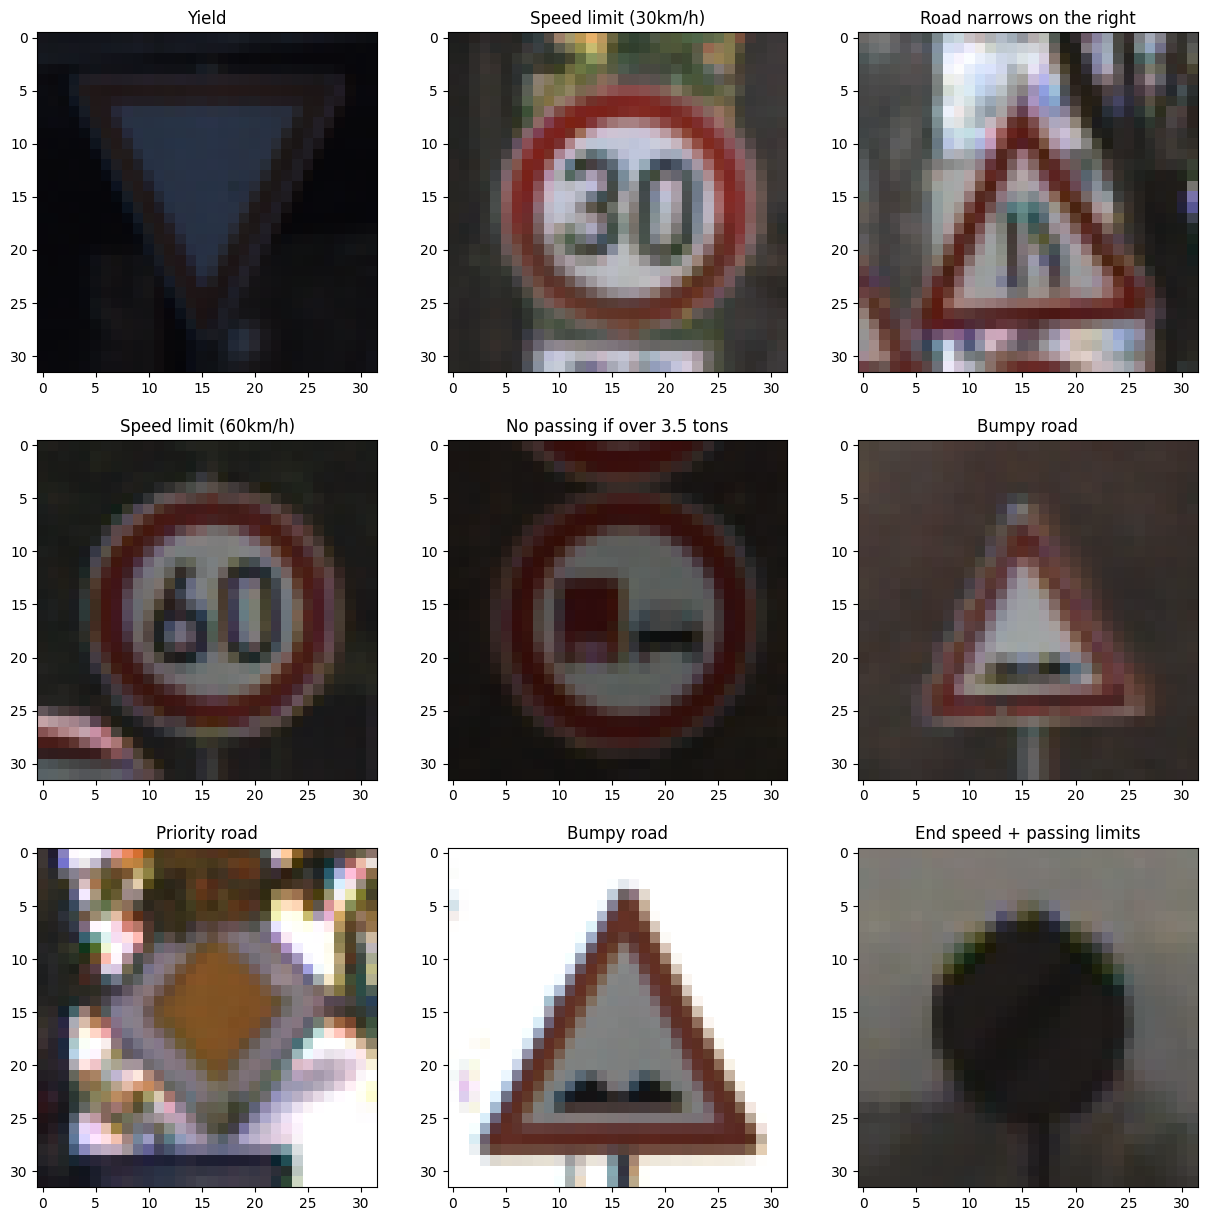

In [9]:
print("\nShape of training data: ", train_data.shape)
print("Shape of test data: ", test_data.shape)
print(f"Number of classes: {num_classes}")
print(f"Images resized to {IMAGE_SIZE} x {IMAGE_SIZE}")

# Plotting random train set examples
plot_size = 3
random_idxs = [random.randint(0, train_data.shape[0]) for i in range(plot_size**2)]
fig = plt.figure(figsize=(15, 15))
for i, index in enumerate(random_idxs):
    a=fig.add_subplot(plot_size,plot_size, i+1)
    imgplot = plt.imshow(train_data[index])
    a.set_title(label_names[str(train_labels[index]+1)])
plt.show()

The dataset in heavily unbalanced, with some classes having only around 200 instances and others having more than 2000, as be seen in the class distribution histogram below. This issue can have a significant impact on model performance and is addressed through data augmentation and oversampling .

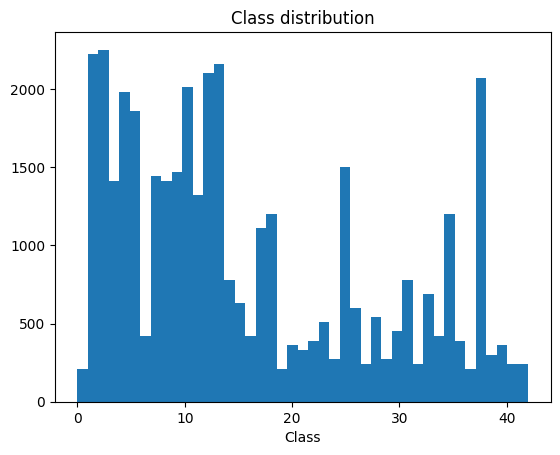

In [10]:
fig, ax = plt.subplots()
values, bins, patches = ax.hist(train_labels, num_classes)
ax.set_xlabel('Class')
ax.set_title('Class distribution')
plt.show()

<a id="md"></a>
### 2. Model Definition and Profiling:

The architecture of the model is loosely based on [AlexNet](https://en.wikipedia.org/wiki/AlexNet), consisting of multiple convolution layers, some followed by max pooling, and mostly using the [ELU](https://deeplearninguniversity.com/elu-as-an-activation-function-in-neural-networks/) activation function. This is followed by a fully connected network, with 2 hidden layers (using RELU) and dropout regularization with p=0.5 to reduce overfitting. Multiple hypermeter variations were tested, with the current one leading to the best performance.

In [11]:
import torch.nn as nn

class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=320, kernel_size=3,padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=320, out_channels=256, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
        )
        
        self.classification = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16*256, 600),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=600, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        X = self.conv(x)
        X = X.view(X.shape[0], -1)
        Y = self.classification(X)
        return Y

<a id='bmt'></a>
### 3. Base Model Training:

To train the model, cross entropy loss showed the best results, using adam optimization for efficiency with a constant learning rate of 0.001. The batch size chosen is 256 examples.

In [13]:
from model import TrafficSignCNN
from torch import optim, nn, save
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from matplotlib.pyplot import Axes, gca, figure, savefig
from torch.utils.data import DataLoader
import pickle

# Loading training dataset
train_set = pickle.load(open("serialized_data/train_data_loader", "rb"))

# Parameters 
num_classes = 43
batch_size = 256
learning_rate = 0.001
EPOCHS = 15

# Train function
def train(model, train_set, optimizer, criterion):
    epoch_ls = 0
    epoch_acc = 0
    model.train()
    for batch_idx, (x, y) in enumerate(train_set):
        optimizer.zero_grad()
        y_pred= model(x)
        loss = criterion(y_pred,y)
        loss.backward()
        final_pred = y_pred.argmax(axis=1)
        accuracy = accuracy_score(final_pred,y)
        optimizer.step()
        epoch_ls += loss.item()
        epoch_acc += accuracy
    return epoch_ls / len(train_set), epoch_acc / len(train_set)

# Initializing CNN, Loss function, and optimizer
model = TrafficSignCNN(num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
transform = transforms.ToTensor()

# Main training logic
train_loss = []
train_accuracy = []
for epoch in range(EPOCHS):
    print("Epoch: ",epoch)
    train_ls, train_acc = train(model, train_set, optimizer, criterion)
    train_loss.append(train_ls)
    train_accuracy.append(train_acc)
    print("Loss: ",train_ls)
    print("Accuracy: ",train_acc)
    
save(model.state_dict(), "serialized_data/model.pt")

Epoch:  0
Loss:  2.438149209146376
Accuracy:  0.3001112359439341
Epoch:  1
Loss:  0.5033012642101808
Accuracy:  0.8339212711830851
Epoch:  2
Loss:  0.16515293751250615
Accuracy:  0.9461180016629711
Epoch:  3
Loss:  0.0869421824183944
Accuracy:  0.9723772321428571
Epoch:  4
Loss:  0.06138157455383667
Accuracy:  0.9806209415584416
Epoch:  5
Loss:  0.06164039061147744
Accuracy:  0.9810014204545454
Epoch:  6
Loss:  0.04771047192414037
Accuracy:  0.9853326932214127
Epoch:  7
Loss:  0.05289167342042284
Accuracy:  0.9842673523123218
Epoch:  8
Loss:  0.05602570588990756
Accuracy:  0.9838107776369971
Epoch:  9
Loss:  0.029818499502393285
Accuracy:  0.9909446022727273
Epoch:  10
Loss:  0.024645300868553918
Accuracy:  0.9920606737012987
Epoch:  11
Loss:  0.04309943275429405
Accuracy:  0.988097506533101
Epoch:  12
Loss:  0.053635869479463014
Accuracy:  0.9853896103896104
Epoch:  13
Loss:  0.03310149246312726
Accuracy:  0.990437297077922
Epoch:  14
Loss:  0.04018708627898542
Accuracy:  0.9897270698

Plotting loss and accuracy over time:

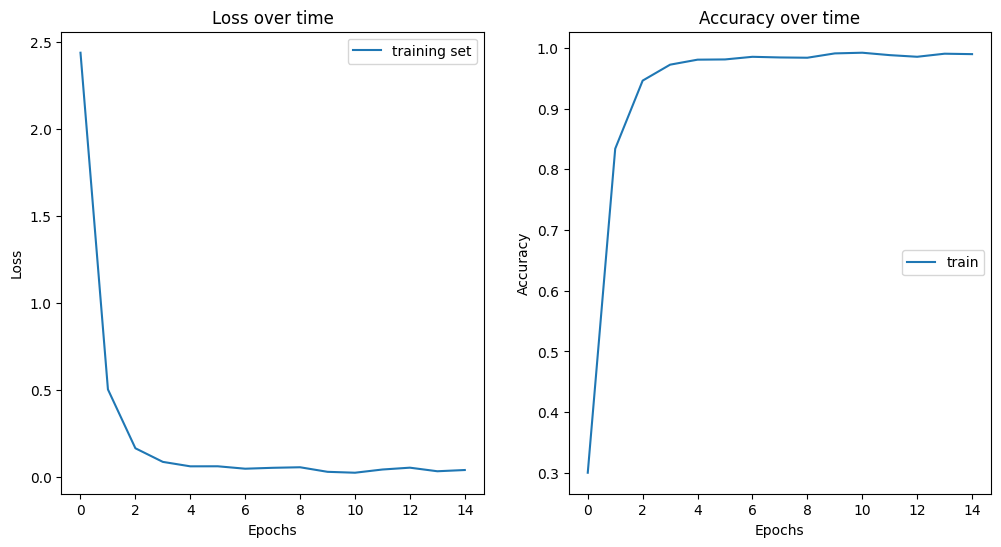

In [14]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(train_loss, label="training set")
axs[0].set_title("Loss over time")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right')
axs[1].plot(train_accuracy, label="train")
axs[1].set_title("Accuracy over time")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right')
plt.show()

A training accuracy of 0.99 is achieved in just 15 epochs. The loss reaches a very small values within just a few iterations, finishing at 0.031. 

<a id='bme'></a>
### 4. Base Model Evaluation:

The test set evaluation of the model reaches an accuracy of 0.95, correctly classifying 12044 images:

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import torch

# Loading test dataset
test_set = pickle.load(open("serialized_data/test_data_loader", "rb"))

true_labels = []
pred_labels = []

# Testing
with torch.no_grad():
    model.eval()
    y_right = 0
    for idx, (x, y) in enumerate(test_set):
        y_pred = model(x)
        final_pred = y_pred.argmax(axis=1)
        if y.item() == final_pred.item():
            y_right += 1
        pred_labels.append(final_pred.item())
        true_labels.append(y.item())

print(f"Correctly classified images: {y_right}")
print(f"Incorrectly classified images: {len(test_set)-y_right}")
print(f"Final Model Accuracy: {y_right/len(test_set)}")
print(classification_report(true_labels,pred_labels))

Correctly classified images: 12036
Incorrectly classified images: 594
Final Model Accuracy: 0.9529691211401425
              precision    recall  f1-score   support

           0       0.92      0.58      0.71        60
           1       0.96      0.98      0.97       720
           2       0.98      0.99      0.99       750
           3       0.95      0.96      0.95       450
           4       0.99      0.98      0.99       660
           5       0.95      0.95      0.95       630
           6       0.99      0.88      0.93       150
           7       0.91      0.95      0.93       450
           8       0.95      0.94      0.95       450
           9       0.93      1.00      0.97       480
          10       1.00      0.97      0.99       660
          11       0.96      0.94      0.95       420
          12       0.99      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      1.00      0.99       270
          15       0.99 

Confusion Matrix: 

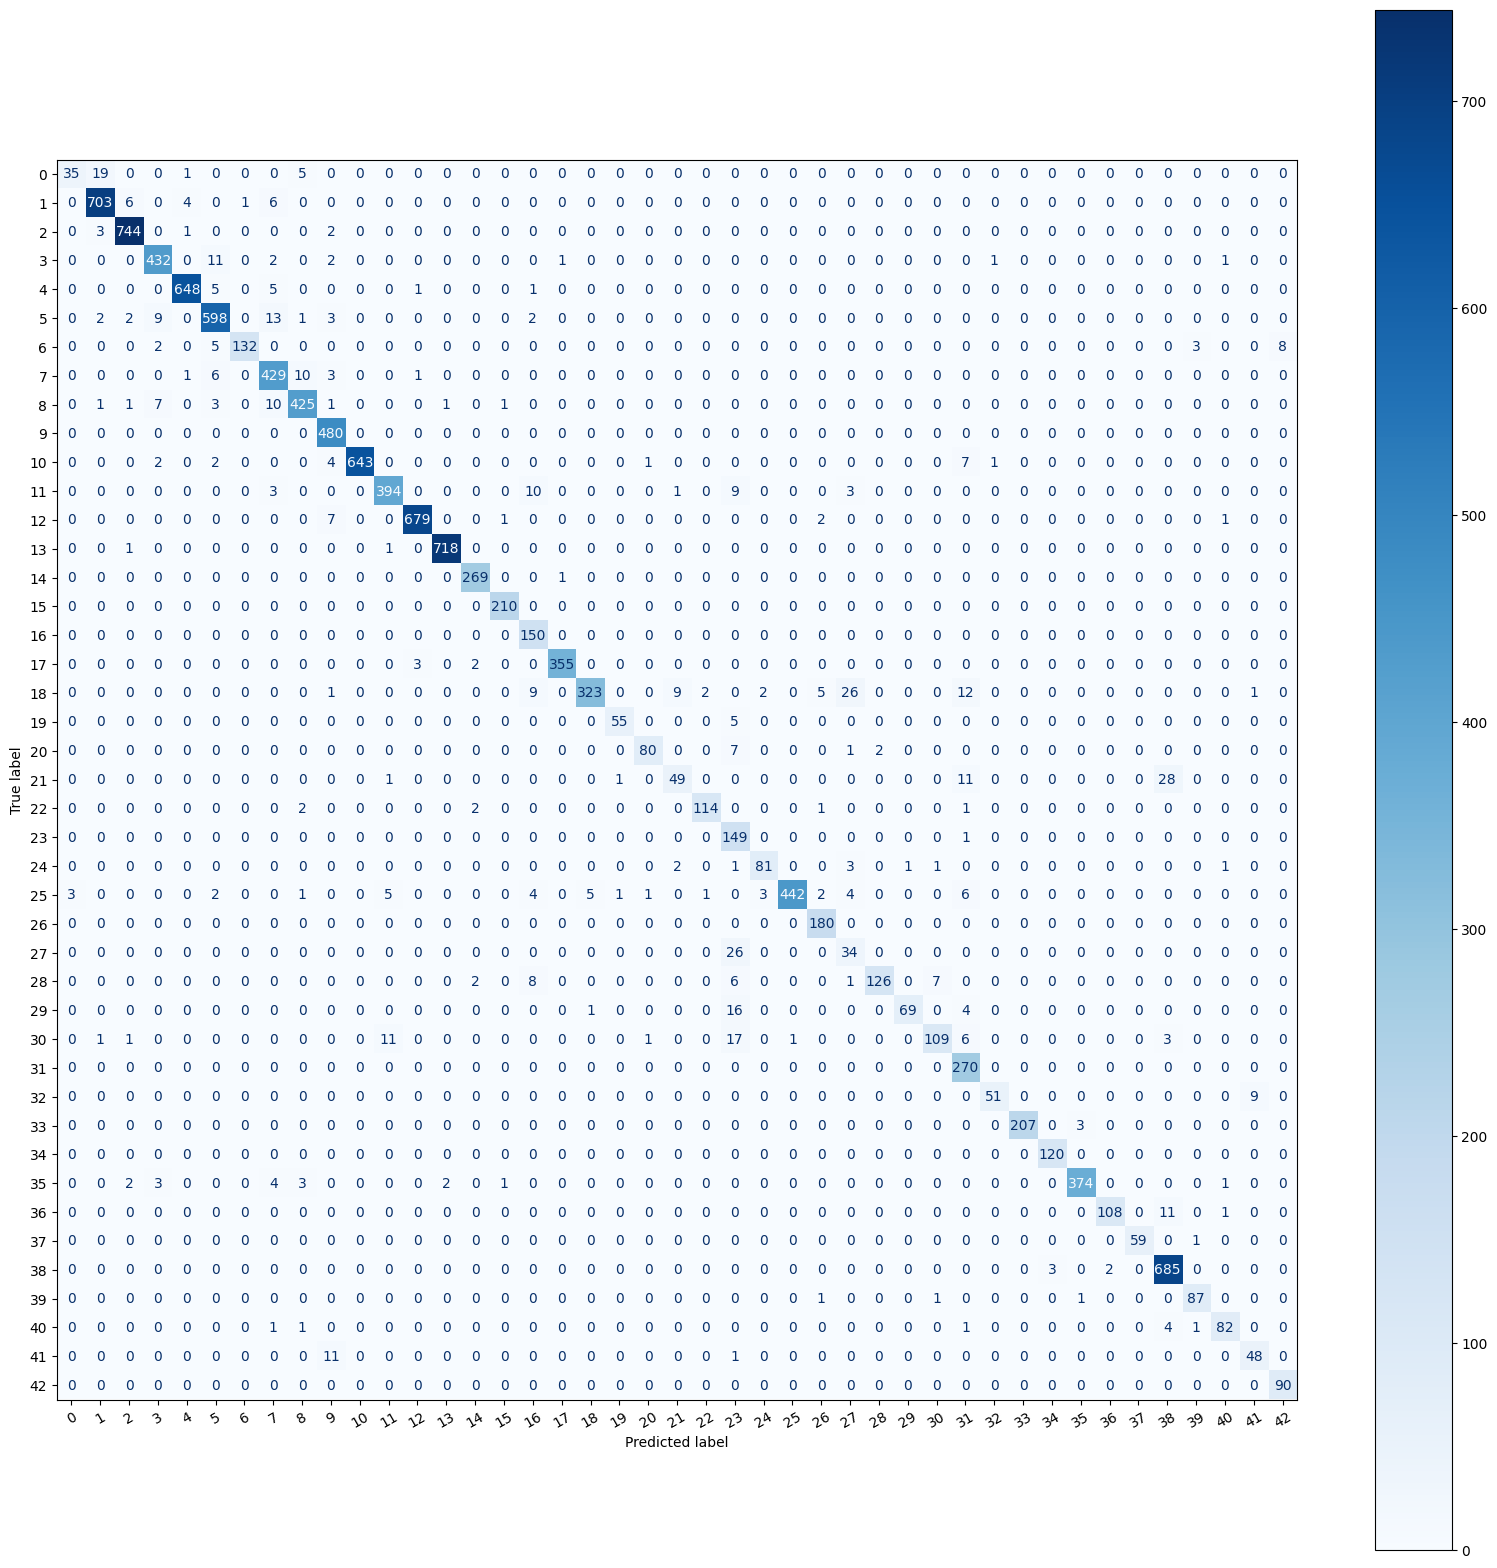

In [16]:
fig = plt.figure(figsize = (20, 20));
ax = fig.add_subplot(1, 1, 1);
cm = confusion_matrix(true_labels, pred_labels);
cm = ConfusionMatrixDisplay(cm, display_labels = range(0, num_classes));
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 30)
plt.show()

To show some examples of predictions, randomly selected images and results are presented:

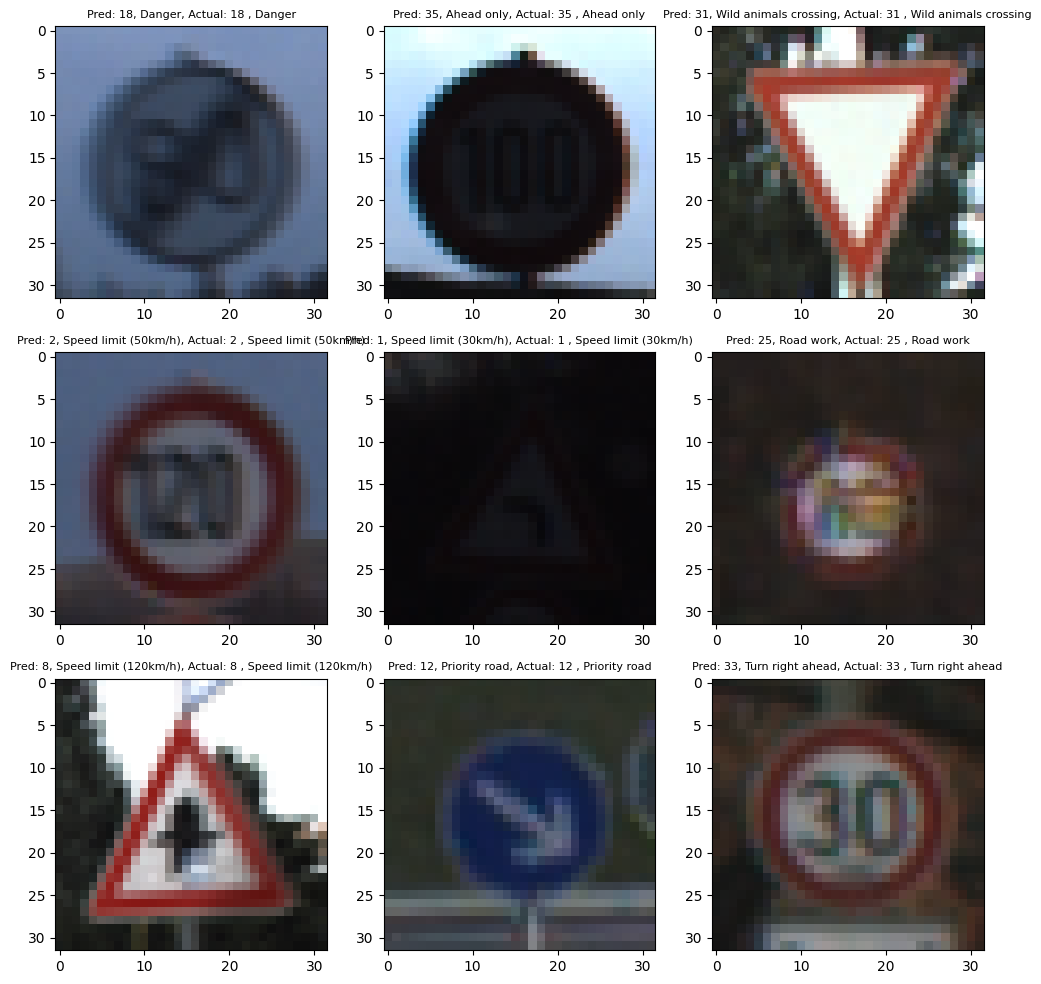

In [17]:
from random import randrange

# Getting random images
num_imgs = 9
random_idxs = [randrange(0,len(test_set)) for i in range(num_imgs)]
imgs = [test_set.dataset.__getitem__(random_idxs[i])[0] for i in range(num_imgs)]

# Calculating plot grid
HEIGHT = 4
NR_COLUMNS = 3
grid = (1,num_imgs)
if num_imgs > NR_COLUMNS:
    grid = (num_imgs // NR_COLUMNS, NR_COLUMNS) if num_imgs % NR_COLUMNS == 0 else (num_imgs // NR_COLUMNS + 1, NR_COLUMNS)

# Plotting images with respective class and prediction
i, j = 0, 0
fig, axs = plt.subplots(grid[0],grid[1],figsize=(grid[1]*HEIGHT,grid[0]*HEIGHT))
for n in range(num_imgs):
    img = imgs[n]
    axs[i, j].imshow(img.permute(1, 2, 0))
    title = f"Pred: {pred_labels[random_idxs[n]]}, {label_names[str(pred_labels[random_idxs[n]]+1)]}, Actual: {true_labels[random_idxs[n]]} , {label_names[str(true_labels[random_idxs[n]]+1)]}"
    axs[i, j].set_title(title, fontsize=8)
    i, j = (i + 1, 0) if (n+1) % grid[1] == 0 else (i, j + 1)

<a id='dprep'></a>
### 5. Data Preparation

#### Balancing

<a id="ap"></a>
### 8. Appendix:

Dataset Loader transforms and definitions: 

In [ ]:
import torch
import torchvision.transforms as transforms 
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class GTRSBDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 7])
        image = Image.open(img_path)
        image = image.resize((32,32))
        y_label = torch.tensor(int(self.annotations.iloc[index, 6]))
        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [2]:
from DatasetLoader import GTRSBDataset
import torchvision.transforms as transforms 
from torch.utils.data import Dataset, DataLoader, random_split
import pickle
import os
import cv2

batch_size = 256

class CLAHE:
    def __init__(self, cl=2.5, tilesize=(4, 4)):
        self.cl = cl
        self.tilesize = tilesize

    def __call__(self, image):
        new_img = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.cl, tileGridSize=self.tilesize)
        new_img = clahe.apply(new_img)
        return new_img.reshape(new_img.shape + (1,))

clahe_transforms = transforms.Compose([
    CLAHE(),
    transforms.ToTensor()
])

if not os.path.exists(os.getcwd() + os.sep + "serialized_data/"):
    os.makedirs(os.getcwd() + os.sep + "serialized_data/")

train_set = GTRSBDataset('data/train.csv','data',transform=transforms.ToTensor()) 
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
pickle.dump(train_loader, open("serialized_data/train_data_loader", "wb"))

test_set = GTRSBDataset('data/test.csv','data',transform=transforms.ToTensor()) 
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)
pickle.dump(test_loader, open("serialized_data/test_data_loader", "wb"))

train_clahe_set = GTRSBDataset('data/train.csv','data',transform=clahe_transforms) 
train_clahe_loader = DataLoader(dataset=train_clahe_set, batch_size=batch_size, shuffle=True)
pickle.dump(train_clahe_loader, open("serialized_data/train_data_loader_clahe", "wb"))

test_clahe_set = GTRSBDataset('data/test.csv','data',transform=clahe_transforms) 
test_clahe_loader = DataLoader(dataset=test_clahe_set, batch_size=1, shuffle=True)
pickle.dump(test_clahe_loader, open("serialized_data/test_data_loader_clahe", "wb"))